<a href="https://colab.research.google.com/github/kthhtk/AIFFEL_Quest_cr/blob/master/MainQuest/MainQuest03/MainQuest03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#개요.

**1. 목표**

>* 폐렴 진단을 위한 딥러닝 모델 개발 및 성능 개선

**2. 과정**

> 2-1. 베이스 모델 구현
* CNN 구조 기반 폐렴 진단 모델 구현
* 기본 성능 측정 및 평가

>2-2. 성능 개선 실험
* 데이터 augmentation 기법을 사용해서 베이스 모델과의 성능을 비교한다.
* 모델의 구조를 변경하여 베이스 모델과의 성능을 비교한다.
* ResNet-18 모델을 구현, 학습하여 성능을 비교한다.

**3. 기대 결과**
>* 진단 정확도 향상
* 개선 방법 별 효과 검증


#목차

1. 전처리 단계
  * 1.1. 실험환경 Set-up
  * 1.2. 데이터 가져오기
  * 1.3. 데이터 셋 생성
  * 1.4. 데이터 시각화

2. 학습 단계
  * 2.1. CNN 모델링
  * 2.2. 데이터 imbalance 처리
  * 2.3. 모델 훈련

3. 평가 단계
  * 3.1. 시각화 그래프
  * 3.2. 모델 평가

4. 회고

##**1. 전처리 단계**

###1-1. 실험환경 Set-up

가장 먼저, 패키지(라이브러리)들을 import 해보겠습니다.

우리가 이번 프로젝트에서 사용할 패키지 목록입니다.

In [12]:
import os, re                         # 'os, re': 시스템/정규식 모듈 임포트          | 역할: 파일/디렉토리 조작, 문자열 패턴 매칭     | 결과: 시스템/문자열 처리 가능
import random, math                   # 'random, math': 난수/수학 모듈 임포트        | 역할: 난수 생성, 수학 함수 연산              | 결과: 확률/수학 계산 실행
import numpy as np                    # 'numpy as np': 넘파이를 np로 임포트          | 역할: 다차원 배열 처리, 행렬 연산            | 결과: 빠른 수치 계산 실행
import tensorflow as tf              # 'tensorflow as tf': 텐서플로우 tf로 임포트    | 역할: 신경망 구현, 자동 미분                | 결과: GPU 가속 학습 수행
import matplotlib.pyplot as plt       # 'matplotlib.pyplot as plt': plt로 임포트     | 역할: 그래프/차트 생성, 데이터 시각화         | 결과: 데이터 분석 시각화
import warnings                      # 'warnings': 경고 모듈 임포트                | 역할: 경고 메시지 관리, 출력 제어            | 결과: 실행 환경 정리
warnings.filterwarnings(action='ignore')  # 'action=ignore': 경고 무시 설정         | 역할: 모든 경고 메시지 비활성화              | 결과: 깔끔한 출력 표시

앞으로 필요한 변수들을 생성합니다.

In [13]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE      # 'AUTOTUNE': 자동 성능 최적화 설정      | 역할: 데이터 파이프라인 최적화     | 결과: 데이터 로딩 속도 향상

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]                       # '[180, 180]': 이미지 크기 지정        | 역할: 입력 이미지 크기 표준화      | 결과: 일관된 이미지 처리

# 경로 설정
ROOT_PATH = '/content/aiffel/data/chest_xray'      # 실제 데이터 루트 경로                | 기능: 데이터 위치 지정              | 결과: 정확한 경로 설정
TRAIN_PATH = ROOT_PATH + '/train/*/*'                         # 훈련 데이터 경로                    | 기능: 훈련 데이터 위치 지정          | 결과: 훈련 데이터 접근
VAL_PATH = ROOT_PATH + '/val/*/*'                            # 검증 데이터 경로                    | 기능: 검증 데이터 위치 지정          | 결과: 검증 데이터 접근
TEST_PATH = ROOT_PATH + '/test/*/*'                          # 테스트 데이터 경로                   | 기능: 테스트 데이터 위치 지정         | 결과: 테스트 데이터 접근

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16                               # 'BATCH_SIZE=16': 배치 크기 설정       | 역할: 학습 단위 데이터 수 지정     | 결과: 메모리 사용량 조절
EPOCHS = 10                                   # 'EPOCHS=10': 학습 반복 횟수 설정      | 역할: 전체 데이터 학습 반복 수     | 결과: 학습 깊이 조절

print(ROOT_PATH)                              # 'print(ROOT_PATH)': 경로 출력        | 역할: 기본 경로 확인              | 결과: 설정된 경로 표시

/content/aiffel/data/chest_xray


###1-2. 데이터 가져오기

코랩에서 진행하기 위해 데이터셋을 다운로드하겟습니다.

In [6]:
# Kaggle에서 데이터셋 직접 다운로드 및 압축 해제
!kaggle datasets download paultimothymooney/chest-xray-pneumonia -p /content/aiffel/data --unzip    # 데이터셋 다운로드 및 압축 해제    | 기능: 데이터 획득 및 설치    | 결과: 데이터 준비 완료

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:27<00:00, 132MB/s]
100% 2.29G/2.29G [00:27<00:00, 90.5MB/s]


데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있습니다. 열어보셨으면 이제 각 데이터들의 개수를 한번 체크해보죠.

아래와 같은 구조의 디렉토리에 이미지 파일들이 각각 담겨있습니다.

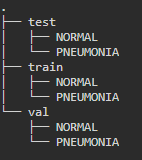

In [14]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)    # 'glob(TRAIN_PATH)': 훈련 파일 목록 생성    | 역할: 훈련 데이터 파일 경로 수집    | 결과: 훈련 데이터 파일 리스트
test_filenames = tf.io.gfile.glob(TEST_PATH)      # 'glob(TEST_PATH)': 테스트 파일 목록 생성   | 역할: 테스트 데이터 파일 경로 수집   | 결과: 테스트 데이터 파일 리스트
val_filenames = tf.io.gfile.glob(VAL_PATH)        # 'glob(VAL_PATH)': 검증 파일 목록 생성     | 역할: 검증 데이터 파일 경로 수집    | 결과: 검증 데이터 파일 리스트

print(len(train_filenames))                       # 'len(train_filenames)': 훈련 파일 수     | 역할: 훈련 데이터 개수 확인        | 결과: 훈련 데이터 규모 표시
print(len(test_filenames))                        # 'len(test_filenames)': 테스트 파일 수    | 역할: 테스트 데이터 개수 확인      | 결과: 테스트 데이터 규모 표시
print(len(val_filenames))                         # 'len(val_filenames)': 검증 파일 수      | 역할: 검증 데이터 개수 확인        | 결과: 검증 데이터 규모 표시

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.

개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

In [15]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)                      # 훈련 데이터 파일 경로 수집           | 기능: 훈련 파일 목록 생성          | 결과: 훈련 파일 리스트 생성
filenames.extend(tf.io.gfile.glob(VAL_PATH))                  # 검증 데이터 파일 경로 추가           | 기능: 검증 파일 목록 추가          | 결과: 전체 파일 리스트 완성

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)                   # 훈련 데이터 크기 계산              | 기능: 80% 비율로 분할 지점 계산     | 결과: 훈련 데이터 수 결정
random.seed(8)                                                # 랜덤 시드 설정                    | 기능: 재현 가능한 결과 보장         | 결과: 일관된 무작위 분할
random.shuffle(filenames)                                     # 파일 목록 무작위 섞기              | 기능: 데이터 랜덤화                | 결과: 무작위로 섞인 파일 목록
train_filenames = filenames[:train_size]                      # 훈련 데이터 분할                  | 기능: 앞 80% 훈련 데이터로 할당     | 결과: 훈련 데이터셋 생성
val_filenames = filenames[train_size:]                        # 검증 데이터 분할                  | 기능: 나머지 20% 검증 데이터로 할당  | 결과: 검증 데이터셋 생성

print(len(train_filenames))                                   # 훈련 데이터 개수 출력              | 기능: 훈련 데이터 규모 확인         | 결과: 훈련 데이터 수 표시
print(len(val_filenames))                                     # 검증 데이터 개수 출력              | 기능: 검증 데이터 규모 확인         | 결과: 검증 데이터 수 표시

4185
1047


이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다.

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.

정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 있네요

In [16]:
print(f'Normal image path\n{filenames[0]}')                   # 정상 이미지 경로 출력              | 기능: 정상 폐 X-ray 경로 확인        | 결과: 첫 번째 정상 이미지 경로 표시
print(f'Pneumonia image path\n{filenames[2000]}')            # 폐렴 이미지 경로 출력              | 기능: 폐렴 환자 X-ray 경로 확인      | 결과: 2000번째 폐렴 이미지 경로 표시

Normal image path
/content/aiffel/data/chest_xray/train/NORMAL/IM-0358-0001.jpeg
Pneumonia image path
/content/aiffel/data/chest_xray/train/PNEUMONIA/person162_virus_319.jpeg


이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다. 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.

In [17]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])           # 정상 이미지 개수 계산              | 기능: 훈련셋의 정상 X-ray 수 집계    | 결과: NORMAL 레이블 파일 수
print(f"Normal images count in training set: {COUNT_NORMAL}")                                    # 정상 이미지 수 출력                | 기능: 정상 케이스 수 표시           | 결과: 훈련용 정상 이미지 수 확인

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])     # 폐렴 이미지 개수 계산              | 기능: 훈련셋의 폐렴 X-ray 수 집계    | 결과: PNEUMONIA 레이블 파일 수
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")                             # 폐렴 이미지 수 출력                | 기능: 폐렴 케이스 수 표시           | 결과: 훈련용 폐렴 이미지 수 확인


Normal images count in training set: 1072
Pneumonia images count in training set: 3113


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

* [mini-batch는 왜 사용하는가?](https://acdongpgm.tistory.com/202)

###1-3. 데이터 셋 생성

In [18]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)        # 훈련 데이터셋 생성                | 기능: 파일명을 텐서로 변환         | 결과: 훈련용 텐서 데이터셋 생성
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)           # 검증 데이터셋 생성                | 기능: 파일명을 텐서로 변환         | 결과: 검증용 텐서 데이터셋 생성

In [19]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()         # 훈련 데이터 개수 계산              | 기능: 훈련용 데이터셋 크기 측정      | 결과: 전체 훈련 이미지 수 추출
print(f"Training images count: {TRAIN_IMG_COUNT}")                                # 훈련 데이터 수 출력               | 기능: 훈련 데이터 규모 표시         | 결과: 훈련 이미지 총 개수 확인

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()            # 검증 데이터 개수 계산              | 기능: 검증용 데이터셋 크기 측정      | 결과: 전체 검증 이미지 수 추출
print(f"Validating images count: {VAL_IMG_COUNT}")                               # 검증 데이터 수 출력               | 기능: 검증 데이터 규모 표시         | 결과: 검증 이미지 총 개수 확인

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없습니다.
파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

노드에서 진행한 코드가

코랩에서 모델 fit 과정에서 bool 오류를 발생하여

해당 코드를 수정해 주었습니다.

In [21]:
# def get_label(file_path):
#     parts = tf.strings.split(file_path, os.path.sep)
#     return tf.cast(parts[-2] == "PNEUMONIA", tf.int32)

def get_label(file_path):  # 이미지 파일 경로에서 라벨 추출 함수  | 기능: 폐렴/정상 분류 레이블 생성  | 결과: 이진 분류 레이블 반환
    # file_path: 이미지 파일의 전체 경로  | 기능: 파일 위치 정보 전달  | 결과: 문자열 경로

    parts = tf.strings.split(file_path, os.path.sep)  # 경로를 구성요소로 분할  | 기능: 경로 문자열을 배열로 변환  | 결과: 디렉토리명 배열

    label = parts[-2] == "PNEUMONIA"  # 폐렴 여부 확인  | 기능: PNEUMONIA 문자열과 비교  | 결과: True/False 불리언 값

    return tf.cast(label, tf.int32)  # 불리언을 정수로 변환  | 기능: True->1, False->0 변환  | 결과: int32 타입의 레이블


이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
decode_img 함수와 process_path 함수를 만들겠습니다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [23]:
# 이미지 디코딩 및 전처리를 위한 함수 정의
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)                    # 설명: JPEG 이미지를 텐서로 변환        | 기능: 이미지 디코딩                | 결과: uint8 텐서 생성
    img = tf.image.convert_image_dtype(img, tf.float32)           # 설명: 이미지 데이터 타입 변환         | 기능: uint8에서 float32로 정규화    | 결과: [0,1] 범위의 float32 텐서
    img = tf.image.resize(img, IMAGE_SIZE)                        # 설명: 이미지 크기 조정              | 기능: 지정된 크기로 리사이즈         | 결과: 균일한 크기의 이미지 텐서
    return img

# 이미지 파일 처리를 위한 함수 정의
def process_path(file_path):
    label = get_label(file_path)                                  # 설명: 파일 경로에서 라벨 추출         | 기능: 라벨 정보 획득               | 결과: 이미지에 대한 라벨값
    img = tf.io.read_file(file_path)                             # 설명: 파일 시스템에서 이미지 로드      | 기능: 이미지 파일 읽기             | 결과: 바이너리 문자열
    img = decode_img(img)                                        # 설명: 이미지 전처리 수행             | 기능: 이미지 디코딩 및 변환         | 결과: 정규화된 이미지 텐서
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

In [24]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)  # 훈련 데이터 전처리  | 기능: 병렬로 이미지 변환 처리  | 결과: 전처리된 훈련 데이터셋
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)      # 검증 데이터 전처리  | 기능: 병렬로 이미지 변환 처리  | 결과: 전처리된 검증 데이터셋

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

In [25]:
for image, label in train_ds.take(1):         # 첫 번째 데이터 추출     | 기능: 훈련셋에서 샘플 선택     | 결과: 데이터 페어 획득
    print("Image shape: ", image.numpy().shape)  # 이미지 형상 출력       | 기능: 이미지 차원 정보 확인    | 결과: 차원 정보 표시
    print("Label: ", label.numpy())             # 레이블 값 출력         | 기능: 이미지의 클래스 확인     | 결과: 클래스 확인


Image shape:  (180, 180, 3)
Label:  0


사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있군요! 참고로, 코드에서 train_ds.take(1)은 하나의 데이터만 가져온다는 의미입니다.

위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.

In [26]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)             # 설명: 테스트 이미지 파일 경로 수집     | 기능: 파일 경로 리스트 생성         | 결과: 파일 경로 데이터셋

TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()    # 설명: 테스트 데이터 개수 계산    | 기능: 데이터셋 크기 측정           | 결과: 테스트 이미지 총 개수

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)       # 설명: 테스트 데이터 전처리       | 기능: 병렬 처리로 이미지 변환       | 결과: 전처리된 이미지-라벨 쌍

test_ds = test_ds.batch(BATCH_SIZE)                                         # 설명: 배치 데이터셋 생성         | 기능: 지정된 크기로 배치화         | 결과: 배치 형태의 데이터셋

print(TEST_IMAGE_COUNT)                                                     # 설명: 테스트 데이터 수 출력      | 기능: 총 이미지 개수 확인          | 결과: 콘솔에 개수 출력

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [27]:
# 데이터셋 학습 준비를 위한 함수 정의
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)              # 설명: 데이터 순서 랜덤화             | 기능: 버퍼 크기만큼 섞기           | 결과: 셔플된 데이터셋
    ds = ds.repeat()                                             # 설명: 데이터셋 무한 반복             | 기능: 에포크 반복 설정             | 결과: 반복 가능한 데이터셋
    ds = ds.batch(BATCH_SIZE)                                    # 설명: 배치 데이터셋 생성             | 기능: 지정된 크기로 배치화         | 결과: 배치 형태의 데이터셋
    ds = ds.prefetch(buffer_size=AUTOTUNE)                      # 설명: 데이터 선행 로딩               | 기능: 다음 배치 미리 로드          | 결과: 최적화된 데이터셋
    return ds

train_ds = prepare_for_training(train_ds)                        # 설명: 학습 데이터 전처리             | 기능: 학습셋 최적화 변환           | 결과: 학습 준비된 데이터셋
val_ds = prepare_for_training(val_ds)                           # 설명: 검증 데이터 전처리             | 기능: 검증셋 최적화 변환           | 결과: 검증 준비된 데이터셋

###1-4. 데이터 시각화

데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

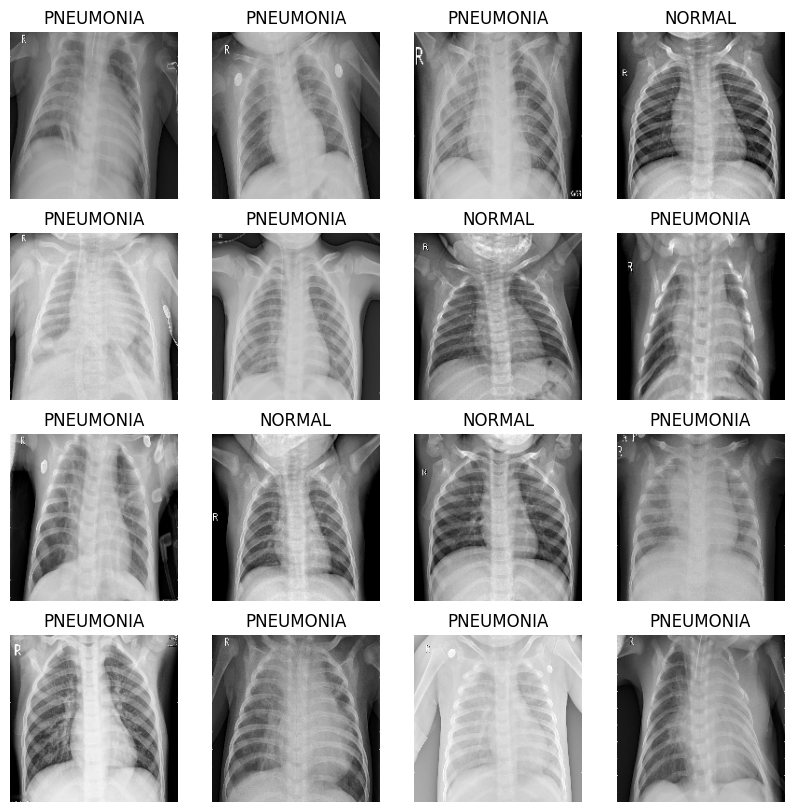

In [ ]:
# 배치 이미지 시각화를 위한 함수 정의
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))                                  # 설명: 전체 그래프 영역 생성          | 기능: 10x10 크기 figure 설정       | 결과: 이미지 표시 영역 확보
    for n in range(BATCH_SIZE):                                  # 설명: 배치 내 각 이미지 순회         | 기능: 배치 크기만큼 반복           | 결과: 모든 이미지 처리
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)         # 설명: 개별 이미지 표시 영역 설정     | 기능: 4xN 그리드 생성             | 결과: 서브플롯 위치 지정
        plt.imshow(image_batch[n])                              # 설명: 단일 이미지 표시              | 기능: n번째 이미지 시각화          | 결과: 이미지 출력
        if label_batch[n]:                                      # 설명: 이미지 라벨 확인              | 기능: 라벨값 조건 검사            | 결과: 제목 설정 조건 분기
            plt.title("PNEUMONIA")                              # 설명: 폐렴 이미지 제목 설정          | 기능: 양성 케이스 표시            | 결과: PNEUMONIA 텍스트 출력
        else:
            plt.title("NORMAL")                                 # 설명: 정상 이미지 제목 설정          | 기능: 음성 케이스 표시            | 결과: NORMAL 텍스트 출력
        plt.axis("off")                                         # 설명: 축 표시 제거                 | 기능: 좌표축 숨김 처리            | 결과: 깔끔한 이미지 표시

# 학습 데이터셋에서 배치 추출 및 시각화
image_batch, label_batch = next(iter(train_ds))                 # 설명: 배치 데이터 추출              | 기능: 다음 배치 가져오기          | 결과: 이미지와 라벨 배치 획득
show_batch(image_batch.numpy(), label_batch.numpy())            # 설명: 배치 시각화 수행              | 기능: 배치 이미지 표시            | 결과: 격자 형태로 이미지 출력

##**2. 학습 단계**

###**2-1. CNN 모델링**


이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보겠습니다.

먼저, Convolution block을 만듭니다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

In [ ]:
# 컨볼루션 블록을 생성하는 함수 정의
# filters: 각 컨볼루션 레이어에서 생성할 필터의 개수를 지정하는 매개변수
def conv_block(filters):
    block = tf.keras.Sequential([                                      # 설명: 순차적 레이어 구성 시작        | 기능: 레이어들을 순차적으로 쌓음    | 결과: Sequential 모델 초기화

        tf.keras.layers.SeparableConv2D(                              # 설명: 첫 번째 분리형 합성곱 수행     | 기능: 입력 특징 맵 생성            | 결과: 필터 수만큼의 특징 맵 생성
            filters,                                                  # 출력 특징 맵의 개수 지정
            3,                                                        # 3x3 크기의 컨볼루션 커널 사용
            activation='relu',                                        # ReLU 활성화 함수로 비선형성 추가
            padding='same'                                            # 입력과 출력의 특징 맵 크기 유지
        ),

        tf.keras.layers.SeparableConv2D(                              # 설명: 두 번째 분리형 합성곱 수행     | 기능: 특징 추출 강화              | 결과: 심화된 특징 맵 생성
            filters,                                                  # 첫 번째 층과 동일한 필터 수 사용
            3,                                                        # 3x3 커널 크기 유지
            activation='relu',                                        # 동일한 활성화 함수 사용
            padding='same'                                            # 특징 맵 크기 유지
        ),

        tf.keras.layers.BatchNormalization(),                         # 설명: 배치 정규화 수행             | 기능: 특징 맵 정규화              | 결과: 학습 안정화 및 속도 향상

        tf.keras.layers.MaxPool2D()                                   # 설명: 최대 풀링 연산 수행           | 기능: 특징 맵 크기 축소           | 결과: 주요 특징만 남긴 압축 데이터
    ])

    return block                                                      # 설명: 구성된 블록 반환             | 기능: 생성된 모델 블록 제공        | 결과: 재사용 가능한 신경망 블록

Dense Block은 아래와 같이 만듭니다.

In [ ]:
# 완전연결층 블록을 생성하는 함수 정의
# units: 뉴런의 개수를 지정하는 매개변수
# dropout_rate: 드롭아웃 비율을 지정하는 매개변수 (0~1 사이 값)
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([                                     # 설명: 순차적 레이어 구성 시작        | 기능: 레이어들을 순차적으로 쌓음    | 결과: Sequential 모델 초기화

        tf.keras.layers.Dense(                                        # 설명: 완전연결층 생성              | 기능: 모든 뉴런을 연결            | 결과: 특징들의 비선형 조합
            units,                                                    # 출력 뉴런의 개수 지정
            activation='relu'                                         # ReLU 활성화 함수로 비선형성 추가
        ),

        tf.keras.layers.BatchNormalization(),                         # 설명: 배치 정규화 수행             | 기능: 은닉층 출력 정규화          | 결과: 학습 안정화 및 속도 향상

        tf.keras.layers.Dropout(                                      # 설명: 드롭아웃 레이어 추가         | 기능: 뉴런 일부 비활성화          | 결과: 과적합 방지
            dropout_rate                                              # 훈련 시 비활성화할 뉴런의 비율
        )
    ])

    return block                                                      # 설명: 구성된 블록 반환             | 기능: 생성된 모델 블록 제공        | 결과: 재사용 가능한 신경망 블록

우리가 만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델입니다. 전형적인 CNN 모델과는 약간 다른 모델입니다.

어떤 부분이 가장 특이한가요? 눈에 띄셨을지 모르겠지만, 방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다.

일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다. 대표적으로 아래와 같은 논문의 사례를 들 수 있습니다.

[Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)

위 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있습니다.

그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있습니다. 아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있습니다.

[Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](https://arxiv.org/pdf/1905.05928)

이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.

In [ ]:
# 폐렴 진단을 위한 CNN 모델 구축 함수 정의
def build_model():
    model = tf.keras.Sequential([                                     # 설명: 순차적 모델 구성 시작         | 기능: 레이어 순차 결합            | 결과: Sequential 모델 초기화

        tf.keras.Input(                                              # 설명: 입력층 정의                 | 기능: 입력 형태 지정             | 결과: 모델 입력 스펙 설정
            shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)                  # 이미지 높이, 너비, 컬러 채널
        ),

        tf.keras.layers.Conv2D(                                      # 설명: 초기 특징 추출 시작          | 기능: 기본 특징 감지             | 결과: 첫 번째 특징 맵 생성
            16, 3,                                                   # 16개 필터, 3x3 커널 크기
            activation='relu',                                       # ReLU 활성화 함수
            padding='same'                                           # 입출력 크기 유지
        ),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),  # 설명: 초기 특징 강화           | 기능: 기본 특징 심화             | 결과: 특징 맵 정교화
        tf.keras.layers.MaxPool2D(),                                 # 설명: 특징 맵 압축                | 기능: 공간 차원 축소             | 결과: 연산량 감소

        conv_block(32),                                             # 설명: 32개 필터 컨볼루션 블록      | 기능: 중간 수준 특징 추출         | 결과: 심화된 특징 표현
        conv_block(64),                                             # 설명: 64개 필터 컨볼루션 블록      | 기능: 고수준 특징 추출           | 결과: 더 복잡한 특징 표현

        conv_block(128),                                            # 설명: 128개 필터 컨볼루션 블록     | 기능: 고차원 특징 추출           | 결과: 추상적 특징 표현
        tf.keras.layers.Dropout(0.2),                               # 설명: 20% 드롭아웃 적용           | 기능: 일부 특징 비활성화          | 결과: 과적합 방지

        conv_block(256),                                            # 설명: 256개 필터 컨볼루션 블록     | 기능: 최종 특징 추출             | 결과: 최종 특징 표현
        tf.keras.layers.Dropout(0.2),                               # 설명: 20% 드롭아웃 적용           | 기능: 특징 일부 제거             | 결과: 모델 일반화

        tf.keras.layers.Flatten(),                                  # 설명: 특징 맵 평탄화              | 기능: 1차원 벡터로 변환          | 결과: 밀집층 입력 준비
        dense_block(512, 0.7),                                      # 설명: 512 유닛 완전연결 블록       | 기능: 고차원 특징 조합           | 결과: 복잡한 패턴 학습
        dense_block(128, 0.5),                                      # 설명: 128 유닛 완전연결 블록       | 기능: 중간 차원 특징 조합        | 결과: 중간 수준 패턴 학습
        dense_block(64, 0.3),                                       # 설명: 64 유닛 완전연결 블록        | 기능: 저차원 특징 조합           | 결과: 단순 패턴 학습

        tf.keras.layers.Dense(1, activation='sigmoid')              # 설명: 출력층 정의                 | 기능: 이진 분류 수행             | 결과: 폐렴 진단 확률 출력
    ])

    return model                                                     # 설명: 구성된 모델 반환             | 기능: 완성된 모델 제공           | 결과: 학습 가능한 CNN 모델

###2-2. 데이터 imbalance 처리

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.

 Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 상세한 내용은 아래 링크를 참고합시다.

* [딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

In [ ]:
# 클래스 불균형 처리를 위한 가중치 계산
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0           # 설명: 정상 클래스 가중치 계산        | 기능: 소수 클래스 보정            | 결과: 정상 샘플 가중치 1.94
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0        # 설명: 폐렴 클래스 가중치 계산        | 기능: 다수 클래스 보정            | 결과: 폐렴 샘플 가중치 0.67

class_weight = {0: weight_for_0, 1: weight_for_1}                 # 설명: 가중치 딕셔너리 생성          | 기능: 클래스별 가중치 매핑         | 결과: 학습에 사용할 가중치 맵

# 계산된 클래스 가중치 출력
print('Weight for NORMAL: {:.2f}'.format(weight_for_0))           # 설명: 정상 클래스 가중치 출력        | 기능: 소수 클래스 가중치 확인      | 결과: 정상 가중치 값 표시
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))        # 설명: 폐렴 클래스 가중치 출력        | 기능: 다수 클래스 가중치 확인      | 결과: 폐렴 가중치 값 표시

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


###2-3. 모델 훈련


이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다.
모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.

성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [ ]:
# GPU 장치에서 모델 생성 및 컴파일 수행
with tf.device('/GPU:0'):                                         # 설명: GPU 장치 지정                 | 기능: 첫 번째 GPU 선택            | 결과: GPU 연산 컨텍스트 생성
    model = build_model()                                         # 설명: 모델 아키텍처 구축            | 기능: CNN 모델 생성              | 결과: 학습 가능한 모델 객체

    METRICS = [                                                   # 설명: 평가 지표 목록 정의           | 기능: 성능 측정 기준 설정         | 결과: 모델 평가 메트릭 리스트
        'accuracy',                                              # 설명: 정확도 지표 추가             | 기능: 전체 정확도 측정           | 결과: 정분류율 계산
        tf.keras.metrics.Precision(name='precision'),             # 설명: 정밀도 지표 추가             | 기능: 양성 예측 정확도 측정       | 결과: 정밀도 계산
        tf.keras.metrics.Recall(name='recall')                   # 설명: 재현율 지표 추가             | 기능: 양성 검출 비율 측정         | 결과: 재현율 계산
    ]

    model.compile(                                               # 설명: 모델 학습 설정                | 기능: 학습 파라미터 구성          | 결과: 컴파일된 모델
        optimizer='adam',                                        # 설명: Adam 옵티마이저 사용          | 기능: 가중치 최적화              | 결과: 학습률 자동 조정
        loss='binary_crossentropy',                             # 설명: 이진 교차 엔트로피 손실 사용   | 기능: 이진 분류 손실 계산         | 결과: 예측 오차 측정
        metrics=METRICS                                          # 설명: 평가 지표 설정               | 기능: 학습 성능 모니터링          | 결과: 다중 성능 지표 추적
    )

모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. 학습하는데 시간이 꽤 걸립니다.

In [ ]:
# GPU를 사용하여 모델 학습 수행
with tf.device('/GPU:0'):                                         # GPU 연산 장치 설정                | 기능: GPU 메모리 할당            | 결과: GPU 가속 환경 구성
    history = model.fit(                                         # 모델 학습 시작                    | 기능: 학습 프로세스 실행          | 결과: 학습 이력 객체 반환
        train_ds,                                               # 학습용 데이터셋 지정               | 기능: 훈련 데이터 공급           | 결과: 배치 단위 데이터 공급
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,          # 에포크당 학습 스텝 수 설정         | 기능: 반복 횟수 지정             | 결과: 전체 데이터 학습 보장
        epochs=EPOCHS,                                          # 전체 학습 반복 횟수 설정           | 기능: 총 학습 주기 지정           | 결과: 지정된 횟수만큼 반복
        validation_data=val_ds,                                 # 검증용 데이터셋 지정               | 기능: 검증 데이터 공급           | 결과: 성능 평가용 데이터 제공
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,           # 검증 스텝 수 설정                 | 기능: 검증 횟수 지정             | 결과: 검증 데이터 평가 횟수
        class_weight=class_weight,                              # 클래스 가중치 적용                | 기능: 불균형 데이터 보정          | 결과: 균형잡힌 학습 수행
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 106s 302ms/step - accuracy: 0.7328 - loss: 0.5102 - precision: 0.9103 - recall: 0.7107 - val_accuracy: 0.7365 - val_loss: 0.6857 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 65s 250ms/step - accuracy: 0.9111 - loss: 0.2342 - precision: 0.9773 - recall: 0.9040 - val_accuracy: 0.7356 - val_loss: 1.3680 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 66s 255ms/step - accuracy: 0.9252 - loss: 0.2041 - precision: 0.9768 - recall: 0.9210 - val_accuracy: 0.7490 - val_loss: 0.6627 - val_precision: 0.7451 - val_recall: 1.0000
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 67s 258ms/step - accuracy: 0.9320 - loss: 0.1963 - precision: 0.9814 - recall: 0.9275 - val_accuracy: 0.7510 - val_loss: 0.5832 - val_precision: 0.7468 - val_recall: 1.0000
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 61s 232ms/step - accuracy: 0.9310 - loss: 0.1593 - precision: 0.9812 - recall: 0.9250 - val_accuracy: 0.969

##**3. 평가 단계**

###3-1 시각화 그래프

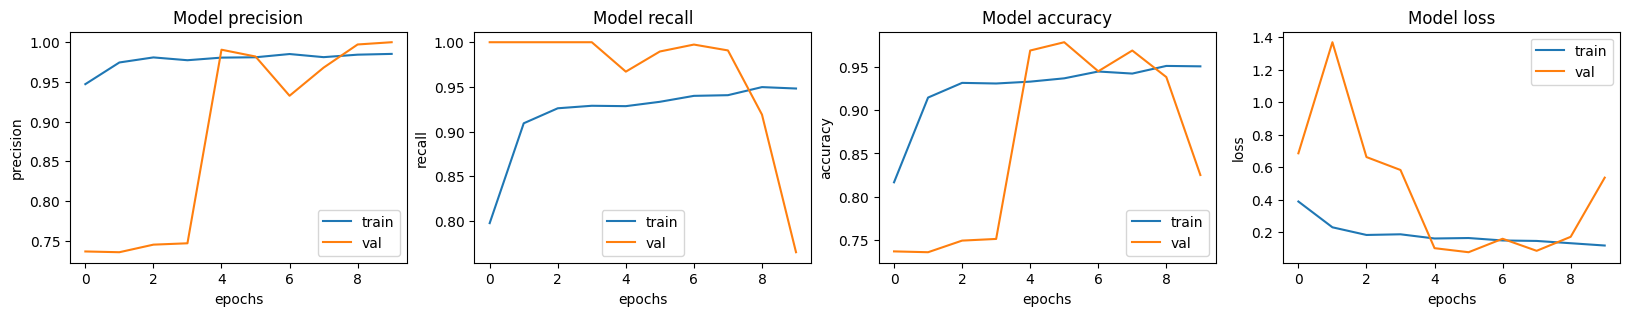

In [ ]:
# 학습 결과를 시각화하는 그래프 생성
fig, ax = plt.subplots(1, 4, figsize=(20, 3))  # 1x4 서브플롯 생성  | 기능: 4개의 지표를 위한 그래프 공간 할당  | 결과: 20x3 인치 크기의 캔버스 생성

ax = ax.ravel()  # 2차원 배열을 1차원으로 변환  | 기능: 서브플롯 배열 평탄화  | 결과: 순차적 접근 가능한 1차원 배열

# 4가지 평가 지표에 대한 그래프 생성 반복문
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):  # 평가 지표 순회  | 기능: 각 지표별 그래프 생성  | 결과: 4개의 개별 성능 그래프
    ax[i].plot(history.history[met])  # 훈련 데이터 그래프  | 기능: 훈련 과정 성능 시각화  | 결과: 에포크별 훈련 성능 곡선
    ax[i].plot(history.history['val_' + met])  # 검증 데이터 그래프  | 기능: 검증 과정 성능 시각화  | 결과: 에포크별 검증 성능 곡선
    ax[i].set_title('Model {}'.format(met))  # 그래프 제목 설정  | 기능: 각 지표 이름 표시  | 결과: 지표별 그래프 식별
    ax[i].set_xlabel('epochs')  # x축 레이블 설정  | 기능: 에포크 수 표시  | 결과: 학습 진행 상황 표시
    ax[i].set_ylabel(met)  # y축 레이블 설정  | 기능: 측정 지표 이름 표시  | 결과: 성능 지표값 범위 표시
    ax[i].legend(['train', 'val'])  # 범례 추가  | 기능: 훈련/검증 구분  | 결과: 데이터 종류 식별

테스트 데이터로 모델 평가를 해보겠습니다.

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.

###3.2 모델 평가

In [ ]:
# 테스트 데이터셋에 대한 모델 성능 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)  # 모델 평가 수행  | 기능: 테스트 데이터로 최종 성능 측정  | 결과: 4가지 평가 지표 계산


# 평가 결과 출력
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')  # 성능 지표 출력  | 기능: 각 지표값 포맷팅 출력  | 결과: 줄바꿈된 4가지 성능 지표 표시

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.8404 - loss: 0.3848 - precision: 0.9080 - recall: 0.8305
Loss: 0.3675800859928131,
Accuracy: 0.8525640964508057,
Precision: 0.9093406796455383,
Recall: 0.8487179279327393


도중에
모델 fit 시의 bool 오류 문제로 def get_label 함수를 수정하며 변경을 줬었는데

>float32 의 경우
* Loss: 0.7228816747665405,
* Accuracy: 0.7916666865348816,
* Precision: 0.7589641213417053,
* Recall: 0.9769230484962463

>int32 의 경우
* Loss: 0.3675800859928131,
* Accuracy: 0.8525640964508057,
* Precision: 0.9093406796455383,
* Recall: 0.8487179279327393

로 loss 결과가 유의미하게 변하는 결과가 있었습니다.

##**4. 회고**




노드에서 진행할때완 다르게 코랩에서만 발생하는 오류들이 종종 있어 해결에 시간이 꽤 오래 걸렸습니다.

베이스 모델을 완성하는데 시간이 오래걸려 성능 개선의 추가 작업들을 진행하지 못했습니다.

노드를 진행하고, 다시 코랩에서 개요, 목차 등을 기재하며 진행하니 조금더 이해되고 개념이 정리된 것 같습니다.

학습에 시간이 오래걸려, 좋은 개발환경이 필요하다 느꼈습니다.



